In [1]:
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_openai import ChatOpenAI
import base64, pathlib
import pickle
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
with open("../outputs/docs.pkl", "rb") as f:
    docs = pickle.load(f)

In [4]:
docs

[Document(metadata={'page': 1, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD\n\nOECD\n\nOECD Economic Outlook, Interim Report\n=====================================\n\n  \n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n=============='),
 Document(metadata={'page': 3, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD Economic Outlook, Interim Report\n=====================================\n\nOECD Economic Outlook, Interim Report\n=====================================\n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n==============\n\nOECD  \nBETTER POLICIES FOR BETTER LIVES'),
 Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='This work is published under the responsibility of the Secretary-General of

In [4]:
llm = ChatOpenAI(model_name="gpt-5-nano", temperature=0.0)

messages_for_image = []

for doc in docs:
    file_paths = doc.metadata["image_path"]
    context = doc.page_content

    if len(file_paths) > 1:
        image_data_arr = []
        for file_path in file_paths:
            file_path_str = "".join(file_path)[1:]
            path = pathlib.Path(file_path_str)
            image_data_arr.append(base64.b64encode(path.read_bytes()).decode("utf-8"))
            
        for idx, image_data in enumerate(image_data_arr):
            
            messages_for_image.append(
                {  
                    "image_id": doc.metadata["image_id"][idx],
                    "prompt":  {
                                    "role": "user",
                                    "content": [
                                        {"type": "text", "text": f"Here is the text of the context.{context}"},
                                        {"type": "text", "text": "Describe content of the image."},
                                        {
                                            "type": "image_url",
                                            "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},            
                                        },
                                    ]
                                }
                }
            )
           
    elif len(file_paths) == 1:
        file_path_str = "".join(file_paths)[1:]
        path = pathlib.Path(file_path_str)
        image_data = base64.b64encode(path.read_bytes()).decode("utf-8")

        messages_for_image.append(
            {  
                "image_id": doc.metadata["image_id"],
                "prompt":  {
                                "role": "user",
                                "content": [
                                    {"type": "text", "text": f"Here is the text of the context.{context}"},
                                    {"type": "text", "text": "Describe content of the image."},
                                    {
                                        "type": "image_url",
                                        "image_url": {"url": f"data:image/jpeg;base64,{image_data}"},            
                                    },
                                ]
                            }
            }
        )       
        


[{'image_id': [46],
  'prompt': {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Here is the text of the context.I 5\n\nI 5\n\n● Countries need to find ways of engaging co-operatively within the global trading system and  \nworking together to make trade policy more transparent and predictable while addressing economic  \nsecurity concerns.  \n· Central banks should remain vigilant and react promptly to shifts in the balance of risks to price  \nstability. Provided inflation expectations remain well anchored, policy interest rate reductions  \nshould continue in economies in which underlying inflation is projected to moderate towards target.  \nMaintaining central bank independence will preserve policy credibility and reduce the volatility and  \npersistence of inflation.  \n· Effective monitoring, supervision, and robust regulatory policies are needed to address financial  \nstability risks.  \n● Fiscal discipline is needed to safeguard longer-term debt sustainability an
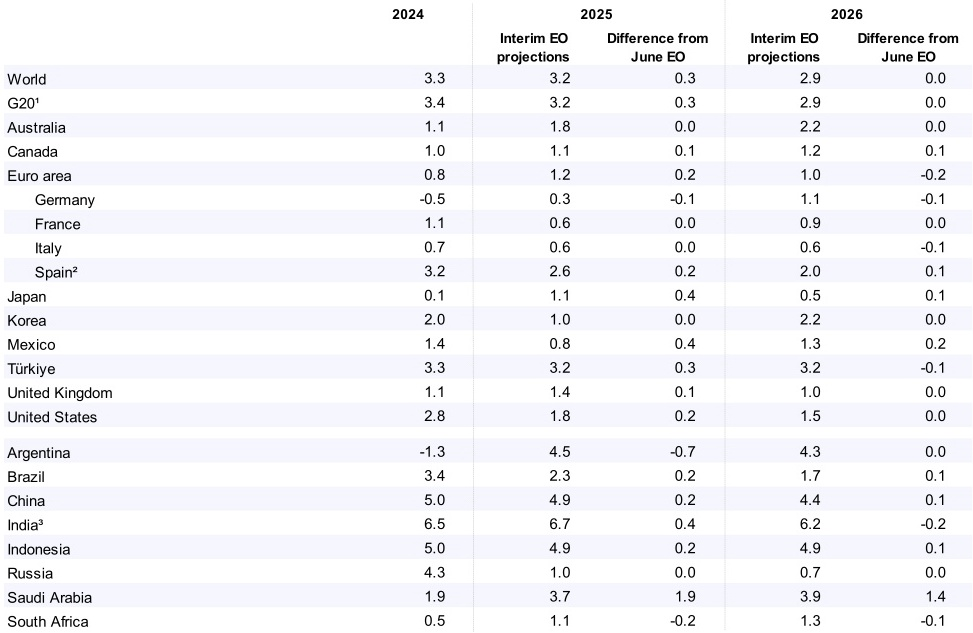
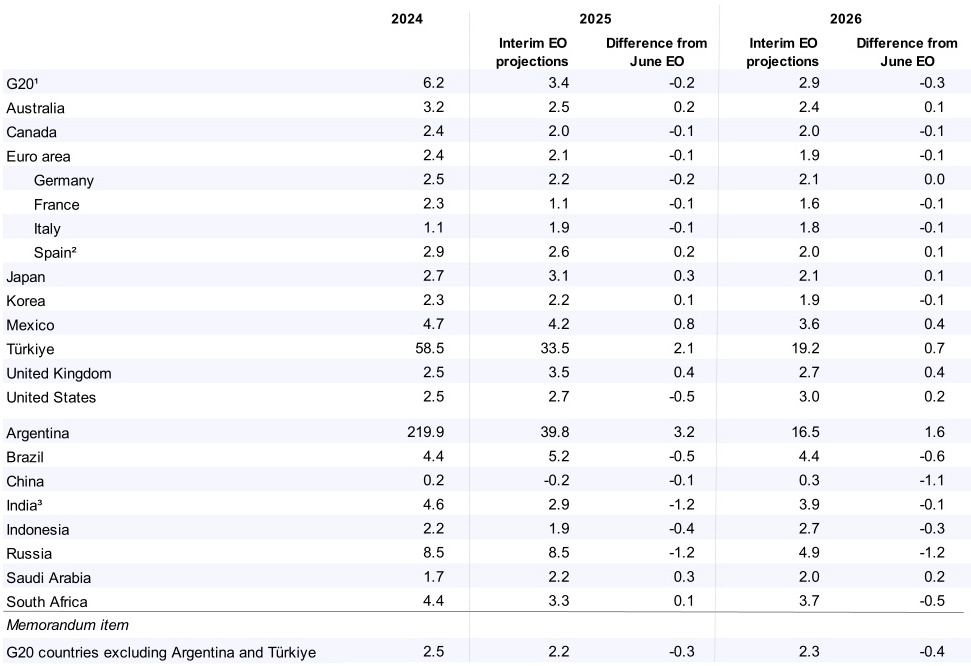
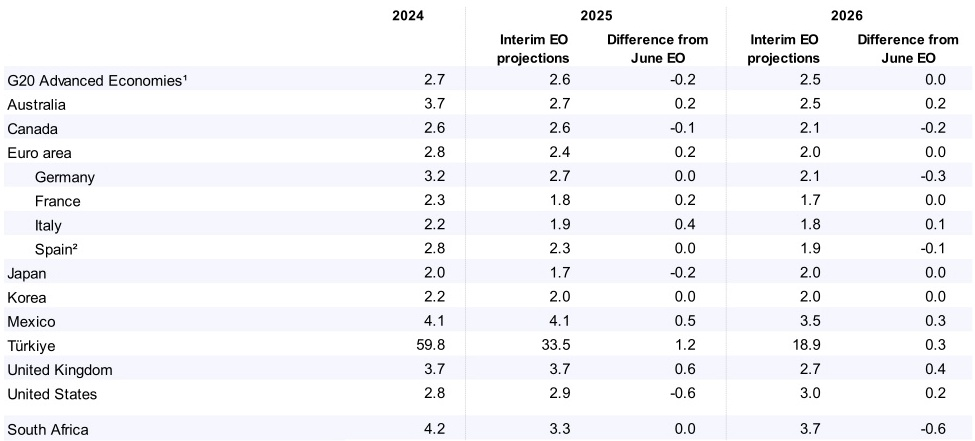
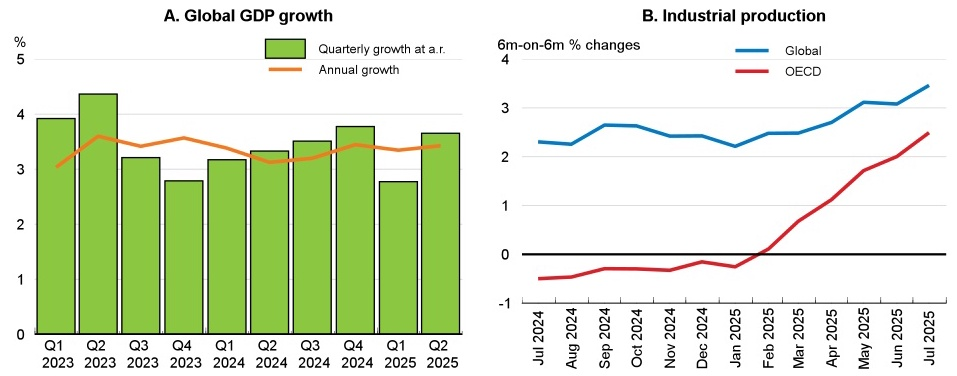
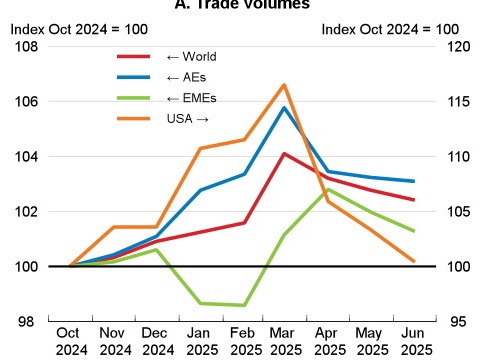
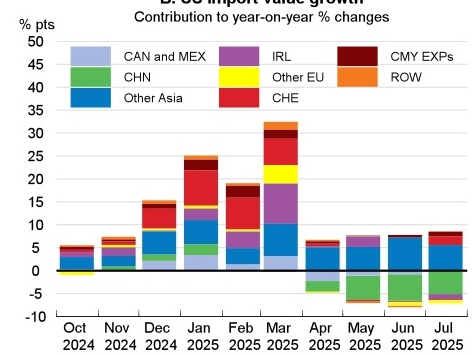
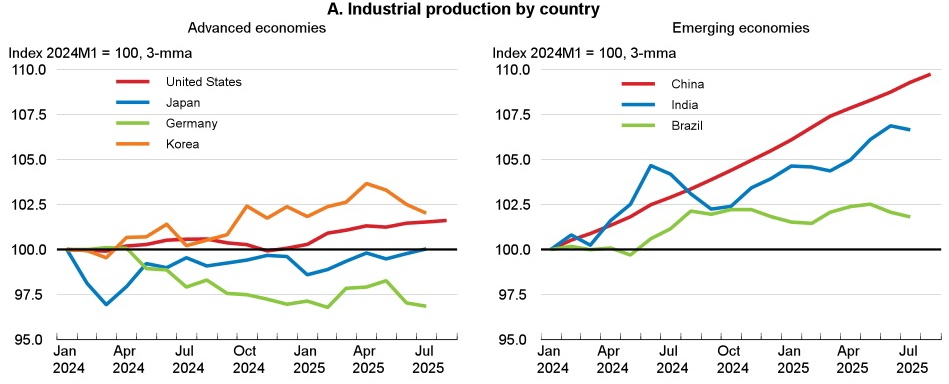
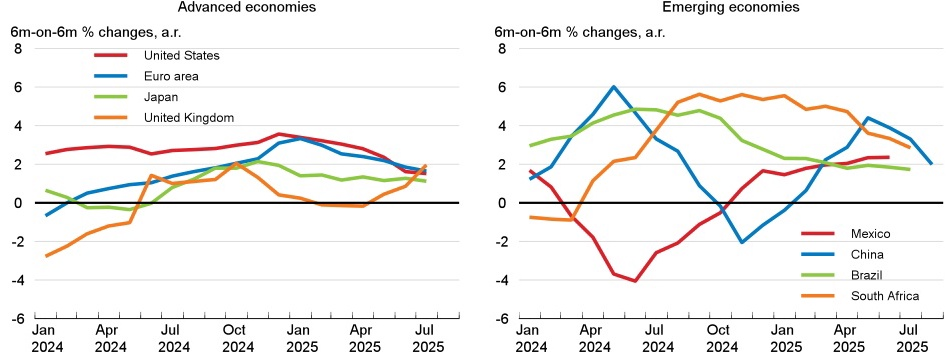
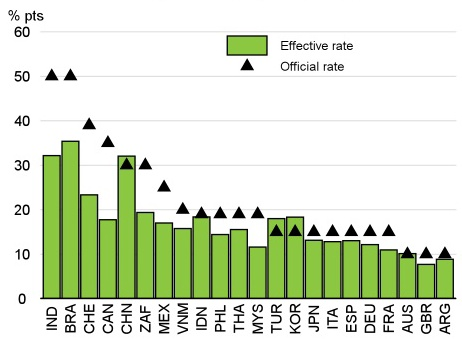
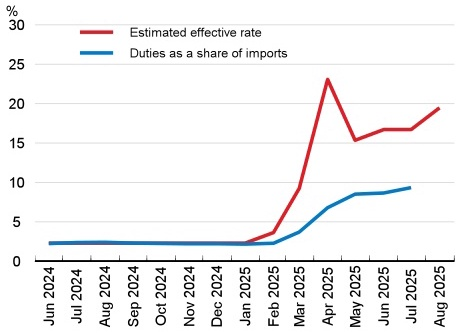
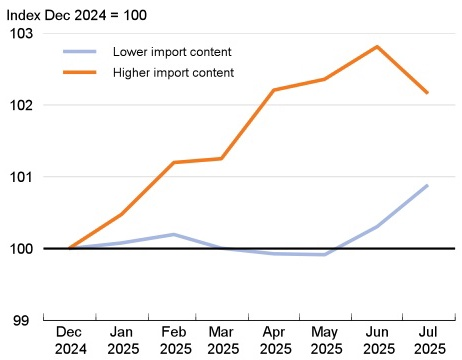
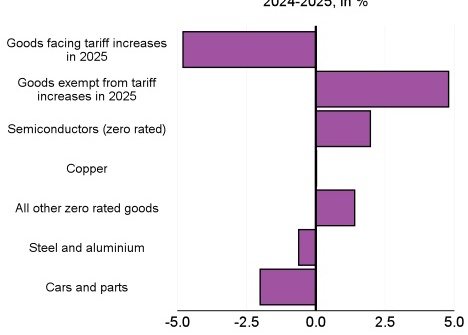
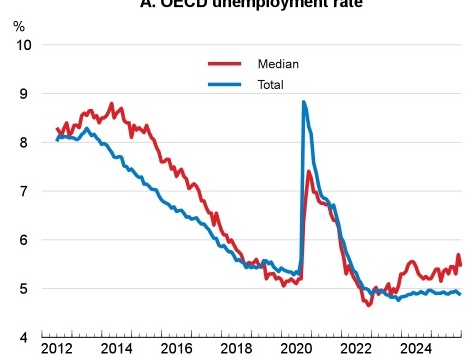
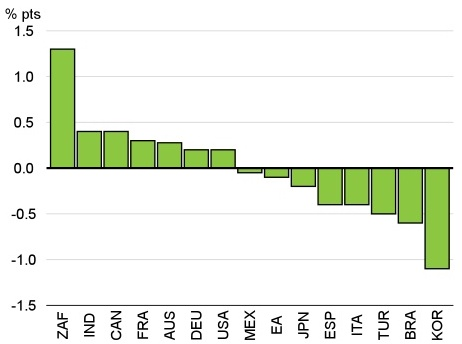
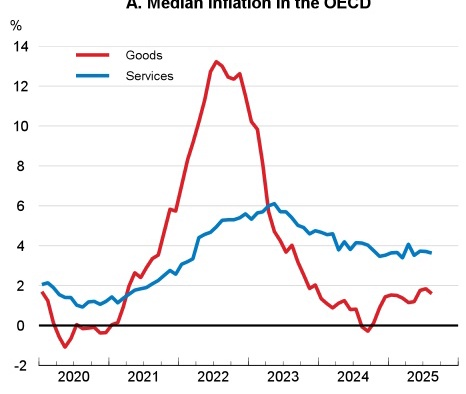
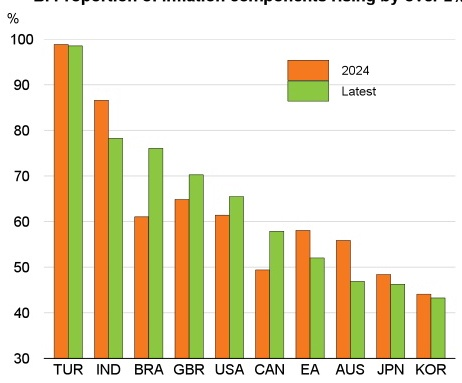
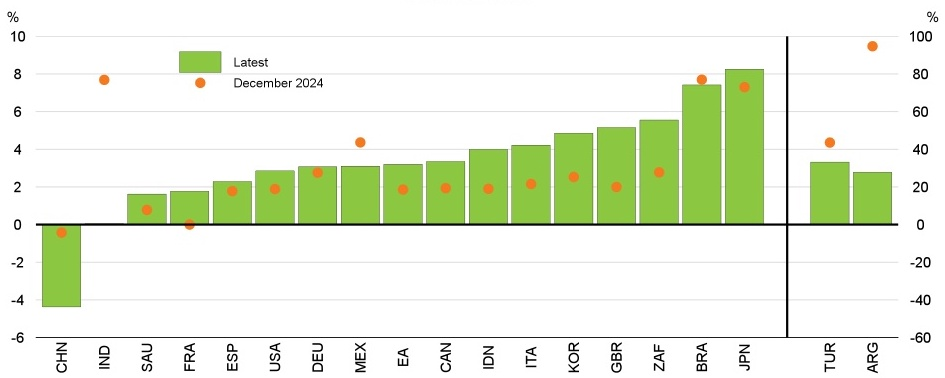
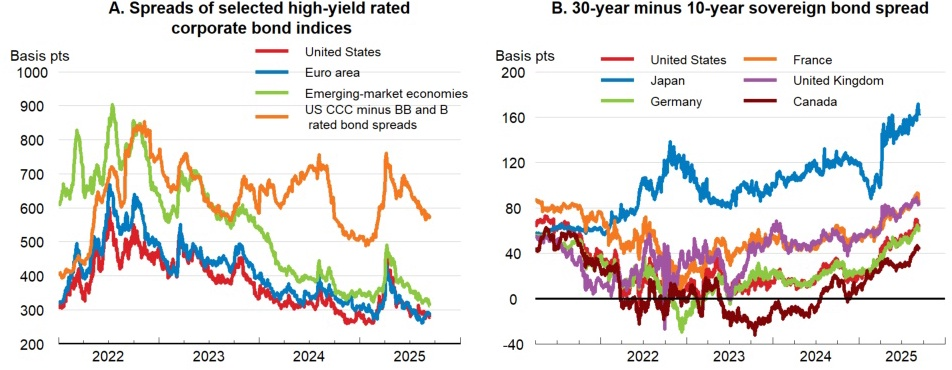
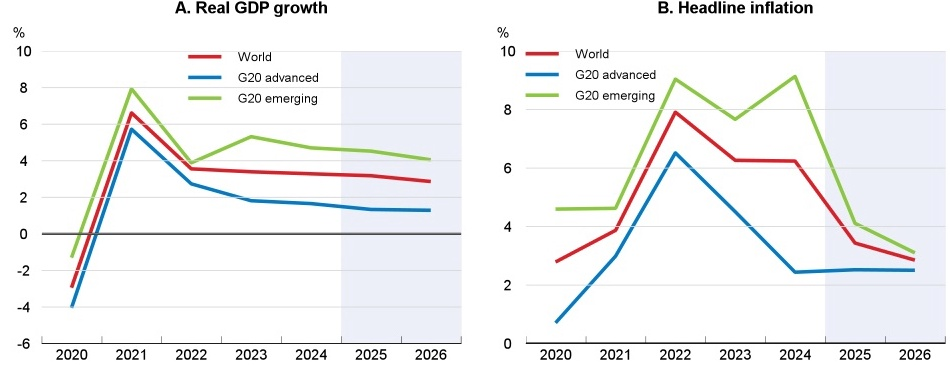
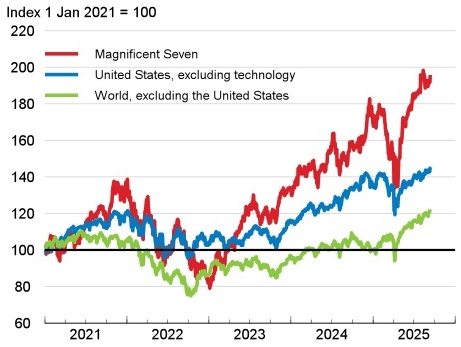
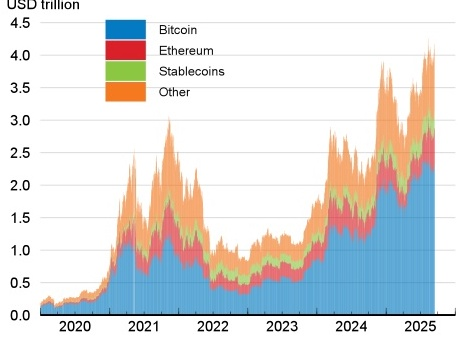
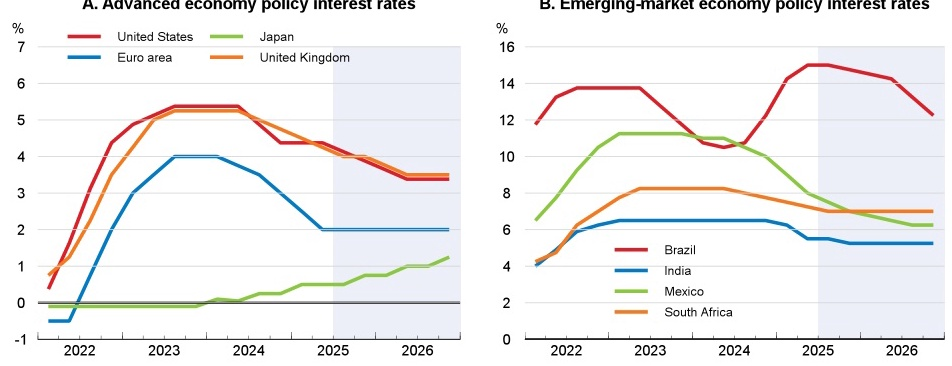
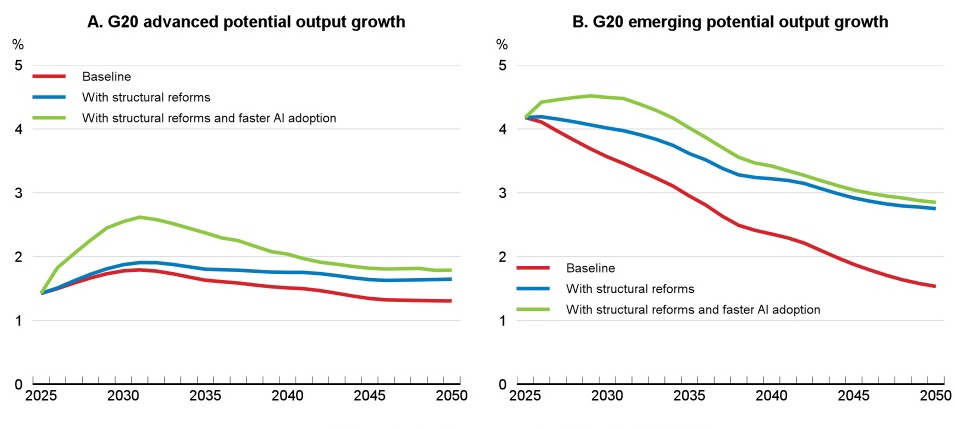
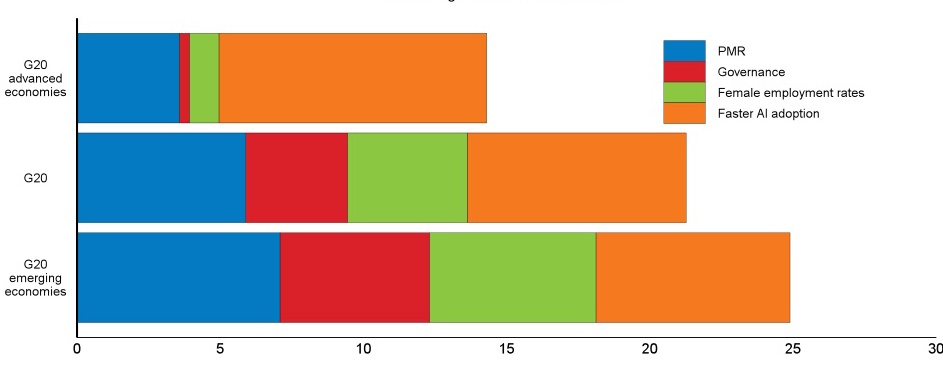

In [5]:
messages_for_image

In [6]:
queries = []
for message in messages_for_image:
    queries.append([message["prompt"]])

In [9]:
len(queries)

24

In [8]:
res = llm.batch(queries)

In [10]:
for idx, message in enumerate(messages_for_image):
    message["image_summary"] = res[idx].content



{'image_id': [46],
 'prompt': {'role': 'user',
  'content': [{'type': 'text',
    'text': 'Here is the text of the context.I 5\n\nI 5\n\n● Countries need to find ways of engaging co-operatively within the global trading system and  \nworking together to make trade policy more transparent and predictable while addressing economic  \nsecurity concerns.  \n· Central banks should remain vigilant and react promptly to shifts in the balance of risks to price  \nstability. Provided inflation expectations remain well anchored, policy interest rate reductions  \nshould continue in economies in which underlying inflation is projected to moderate towards target.  \nMaintaining central bank independence will preserve policy credibility and reduce the volatility and  \npersistence of inflation.  \n· Effective monitoring, supervision, and robust regulatory policies are needed to address financial  \nstability risks.  \n● Fiscal discipline is needed to safeguard longer-term debt sustainability and ma
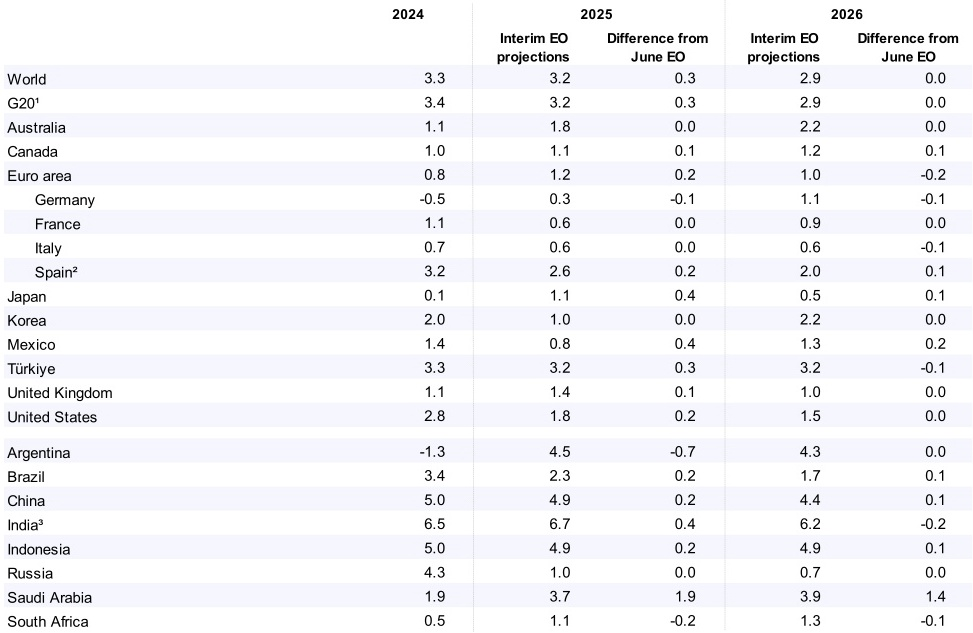

In [11]:
messages_for_image[0]

In [12]:
for doc in docs:
    for message in messages_for_image:
        if len(doc.metadata["image_id"]) == 1:
            if doc.metadata["image_id"] == message["image_id"]:
                doc.metadata["image_summary"] = message["image_summary"]
        else:
            for image_id in doc.metadata["image_id"]:
                if image_id == message["image_id"]:
                    doc.metadata["image_summary"].append(message["image_summary"])
                    


In [13]:
docs[-2].metadata["image_summary"]

['- The image shows two line charts titled:\n  - A. G20 advanced potential output growth\n  - B. G20 emerging potential output growth\n\n- There are three scenario lines in each chart:\n  - Red line: Baseline\n  - Blue line: Baseline with structural reforms\n  - Green line: With structural reforms and faster AI adoption\n\n- Time axis (x-axis) runs from 2025 to 2050.\n\n- Percentage growth axis (y-axis) runs from 0% up to about 5%.\n\n- In the advanced economies (Panel A):\n  - The red baseline starts around 4.5% in 2025 and declines toward roughly 1% by 2050.\n  - The blue line (structural reforms) stays slightly above the red baseline over time.\n  - The green line (structural reforms plus faster AI adoption) rises in the early decades—peaking around the early 2030s—at roughly 2.5% or so, and then gradually declines, ending near or just above 2% by 2050.\n\n- In the emerging economies (Panel B):\n  - The red baseline starts around 4% in 2025 and falls to about 1% by 2050.\n  - The bl

In [14]:
def word_count(text):
    return len(text.split())

In [15]:
word_count(docs[2].page_content)

566

In [16]:
docs[2]

Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='This work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis document, as well as any data and map included herein, are without prejudice to the status of or sovereignty over  \nany territory, to the delimitation of international frontiers and boundaries and to the name of any territory, city or area.\n\nThe statistical data for Israel are supplied by and under the responsibility of the relevant Israeli authorities. The use of  \nsuch data by the OECD is without prejudice to 

In [17]:
messages_for_text = []
for idx, doc in enumerate(docs):
    if word_count(doc.page_content) > 500:
        context = doc.page_content
        message = {
                    "page": doc.metadata["page"],
                    "prompt": {
                        "role": "user",
                        "content": [
                            {"type": "text", "text": f"Here is the text of the context.{context}"},
                            {"type": "text", "text": "Summarize the text "},
                        ]
                    }
                }
            
        
        messages_for_text.append(message)
        

In [18]:
messages_for_text

[{'page': 4,
  'prompt': {'role': 'user',
   'content': [{'type': 'text',
     'text': 'Here is the text of the context.This work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis work is published under the responsibility of the Secretary-General of the OECD. The opinions expressed and  \narguments employed herein do not necessarily reflect the official views of the Member countries of the OECD.\n\nThis document, as well as any data and map included herein, are without prejudice to the status of or sovereignty over  \nany territory, to the delimitation of international frontiers and boundaries and to the name of any territory, city or area.\n\nThe statistical data for Israel are supplied by and under the responsibility of the relevant Israeli authorities. The use of  \nsuch data by the OECD is without prejudice to 

In [19]:
queries_text = []
for message in messages_for_text:
    queries_text.append([message["prompt"]])

In [20]:
res_text = llm.batch(queries_text)

In [21]:
len(res_text)

13

In [22]:
res_text[0]

AIMessage(content='- This is a licensing and attribution notice for OECD Publishing, specifically the OECD Economic Outlook, Interim Report September 2025: Finding the Right Balance in Uncertain Times.\n- Responsibility: Published under the responsibility of the OECD Secretary-General; the opinions and arguments do not necessarily reflect all OECD member governments.\n- Territorial and data notes: \n  - Data for Israel are provided by Israeli authorities and OECD data usage does not affect the status of the Golan Heights, East Jerusalem, or Israeli settlements.\n  - Note by Turkiye regarding Cyprus: explains Cyprus-related sensitivities and recognitions (TRNC vs. the Republic of Cyprus).\n  - Note by all EU Member States: Cyprus is recognized by all UN members except Turkiye; content relates to areas under the Government of the Republic of Cyprus.\n- Publication details: includes citation format, authorship, DOI, ISBNs (PDF and HTML), and ISSNs (print and online).\n- Licensing: The wor

In [23]:
for idx, message in enumerate(messages_for_text):
    message["summary"] = res_text[idx].content 
    

In [24]:
messages_for_text[0]["page"]

4

In [25]:
for doc in docs:
    for message in messages_for_text:
        if doc.metadata["page"] == message["page"]:
            doc.metadata["text_summary"] = message["summary"]           
            


In [26]:
docs[4]

Document(metadata={'page': 6, 'image_id': [], 'image_path': [], 'text_summary': 'A concise summary:\n\n- Growth remained resilient in early 2025, helped by emerging markets, AI-related investment in the US, and Chinese fiscal support, which offset some trade headwinds and weakness in housing/real estate.\n- US bilateral tariff rates rose to about 19.5% by August, with many changes phased in. The full effects are still unfolding, but early signs show effects on spending, labor markets, and prices, including some softening in jobs markets.\n- Inflation has paused its decline: disinflation has leveled off, with rising food prices lifting goods inflation and services inflation remaining persistent.\n- Financial conditions have eased, asset prices are buoyant, credit is improving, and corporate spreads are low, but valuations look stretched and fiscal risks are rising.\n- Outlook: Global GDP growth is projected to slow from 3.3% in 2024 to 3.2% in 2025 and 2.9% in 2026. The US is expected t

In [27]:
# 단계 2: 문서 분할(Split Documents)
text_splitter = RecursiveCharacterTextSplitter(chunk_size=1000, chunk_overlap=50)
split_documents = text_splitter.split_documents(docs)
print(f"분할된 청크의수: {len(split_documents)}")

분할된 청크의수: 109


In [28]:
split_documents

[Document(metadata={'page': 1, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD\n\nOECD\n\nOECD Economic Outlook, Interim Report\n=====================================\n\n  \n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n=============='),
 Document(metadata={'page': 3, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': []}, page_content='OECD Economic Outlook, Interim Report\n=====================================\n\nOECD Economic Outlook, Interim Report\n=====================================\n\nFinding the Right Balance in Uncertain Times\n============================================\n\nSeptember 2025\n==============\n\nOECD  \nBETTER POLICIES FOR BETTER LIVES'),
 Document(metadata={'page': 4, 'image_id': [], 'image_path': [], 'text_summary': '- This is a licensing and attribution notice for OECD Publishing, specifically the OECD Economic Outlook, Interim 

In [29]:
for i, doc in enumerate(split_documents):
    doc.metadata['id'] = i

In [30]:
split_documents[-1]

Document(metadata={'page': 24, 'image_id': [], 'image_path': [], 'text_summary': [], 'image_summary': [], 'id': 108}, page_content='The Interim Report says that countries need to find ways of engaging co‑operatively within the global trading system  \nand working together to make trade policy more transparent and predictable. Central banks should remain vigilant, but  \ncan lower policy interest rates where underlying inflation is projected to moderate towards target, provided inflation  \nexpectations remain well anchored. Fiscal discipline is needed to safeguard longer‑term debt sustainability and allow  \ngovernments to react to future shocks. Enhanced structural reform efforts are required to durably improve living  \nstandards and help realise the potential from new technologies, such as artificial intelligence.\n\n  \n\nThe Interim Report is an update on the assessment in the June 2025 of the Economic Outlook (Volume 2025 Issue 1).\n\nPDF ISBN 978-92-64-57606-3\n\n  \n\n9HSTCQE\\

In [31]:
# 청킹 테스트 문서
delimiter = "\n\n\n" + ("---" * 50) + "\n\n\n"
split_documents_text = delimiter.join([doc.page_content for doc in split_documents])
with open("outputs/split_documents.txt", "w", encoding="utf-8") as f:
    f.write(split_documents_text)

In [32]:
with open('outputs/split_documents.pkl', 'wb') as f:
    pickle.dump(split_documents, f)